# Actividad para resolver la tarea de análisis de sentimientos en textos

Hemos estudiado y comprendido los conceptos de los modelos secuenciales Ahora, aplicaremos estos conceptos en una tarea de análisis de sentimientos en comentarios de películas. Para este problema, usamos la base de datos disponible en [IMDB](https://keras.io/api/datasets/imdb/).


## Etapa 1: Se carga la base de datos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense, TextVectorization, Bidirectional
from tensorflow.keras.utils import plot_model
from IPython.display import Image

In [153]:
# Cargar el dataset de IMDB con etiquetas supervisadas (texto, etiqueta)

dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [154]:
# Mostrar cuántos datos tiene la base de datos
print("Número de ejemplos en el conjunto de entrenamiento:", info.splits['train'].num_examples)
print("Número de ejemplos en el conjunto de prueba:", info.splits['test'].num_examples)

# Contar ejemplos por clase en el conjunto de entrenamiento
train_counts = {0: 0, 1: 0}
for _, label in dataset['train']:
    train_counts[int(label.numpy())] += 1

print("Conjunto de entrenamiento:")
print(f"  Negativos (0): {train_counts[0]}")
print(f"  Positivos (1): {train_counts[1]}")

# Contar ejemplos por clase en el conjunto de prueba
test_counts = {0: 0, 1: 0}
for _, label in dataset['test']:
    test_counts[int(label.numpy())] += 1

print("Conjunto de prueba:")
print(f"  Negativos (0): {test_counts[0]}")
print(f"  Positivos (1): {test_counts[1]}")

Número de ejemplos en el conjunto de entrenamiento: 25000
Número de ejemplos en el conjunto de prueba: 25000
Conjunto de entrenamiento:
  Negativos (0): 12500
  Positivos (1): 12500
Conjunto de prueba:
  Negativos (0): 12500
  Positivos (1): 12500


In [155]:
# Se imprime un ejemplo de la base de datos. Este ejemplo corresponde a un
# comentario negativo; así, su etiqueta es 0.
for example, label in train_dataset.take(5):
  print('Texto: ', example.numpy())
  print('Etiqueta: ', label.numpy())

Texto:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
Etiqueta:  0
Texto:  b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubb

In [156]:
# Se generan mini-lotes de la base de datos
# Configura el tamaño del buffer y tamaño del batch

buffer_size = 10000
batch_size = 64

# Agrupar en batches y preparar para prefetching (mejora rendimiento)

train_dataset = train_dataset.shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Etapa 2: Procesamiento de textos

Recordemos que los modelos de aprendizaje no funcionan cuando las entradas son textos. Así, es necesaria una primera etapa en donde codifiquemos, de forma numérica, las cadenas de caracteres.

In [157]:
#Antes de definir el modelo, debemos convertir los textos en vectores numéricos. Puedes usar TextVectorization de Keras para esto:


# Configuramos la capa de vectorización
#Tamaño del vocabulario y longitud máxima de secuencia
max_features = 10000  # Número máximo de palabras en el vocabulario
sequence_length = 250  # Longitud de las secuencias

# Capa de vectorización de texto
vectorize_layer = TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Adaptamos la capa al texto del conjunto de entrenamiento
train_text = train_dataset.map(lambda text, label: text)
vectorize_layer.adapt(train_text)

# Función para aplicar la vectorización a texto y etiqueta
def vectorize_text(text, label):
    text = vectorize_layer(text)
    return text, label

# Aplicamos la vectorización al conjunto de entrenamiento y prueba
train_dataset = train_dataset.map(vectorize_text)
test_dataset = test_dataset.map(vectorize_text)


## Etapa 3: Definición del modelo



In [165]:
# Vamos a usar un modelo secuencial simple con una capa de Embedding, seguida por una capa LSTM (modelo secuencial típico para texto):
# Definición de la arquitectura del modelo

def createmodel():
    model = Sequential([
        Embedding(input_dim=max_features, output_dim=64, input_length=sequence_length),
        Bidirectional(LSTM(64)),  # Captura información hacia adelante y hacia atrás
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    return model

# Crear y compilar el modelo

model = createmodel()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Mostrar la arquitectura textual del modelo
model.summary()



Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_11                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Etapa 4: Entrenamiento y evaluación del modelo

In [166]:
# Mostrar la arquitectura textual del modelo

epochs = 5

history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=epochs)

# Evaluar el modelo

test_loss, test_acc = model.evaluate(test_dataset)
print(f'\nPrecisión en el conjunto de prueba: {test_acc:.2%}')


Epoch 1/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.6402 - loss: 0.6268 - val_accuracy: 0.7863 - val_loss: 0.4704
Epoch 2/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.8548 - loss: 0.3623 - val_accuracy: 0.8482 - val_loss: 0.3691
Epoch 3/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.9090 - loss: 0.2510 - val_accuracy: 0.8420 - val_loss: 0.3755
Epoch 4/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9296 - loss: 0.1974 - val_accuracy: 0.8280 - val_loss: 0.4129
Epoch 5/5
391/391 ━━━━━━━━━━━━━━━━━━━━ 14s 36ms/step - accuracy: 0.9330 - loss: 0.1857 - val_accuracy: 0.8452 - val_loss: 0.4394
391/391 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.8455 - loss: 0.4385

Precisión en el conjunto de prueba: 84.52%


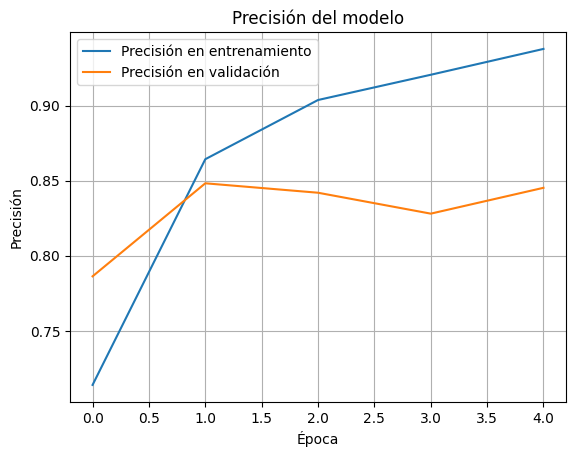

In [167]:
# Evaluar el modelo
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()
plt.grid(True)
plt.show()


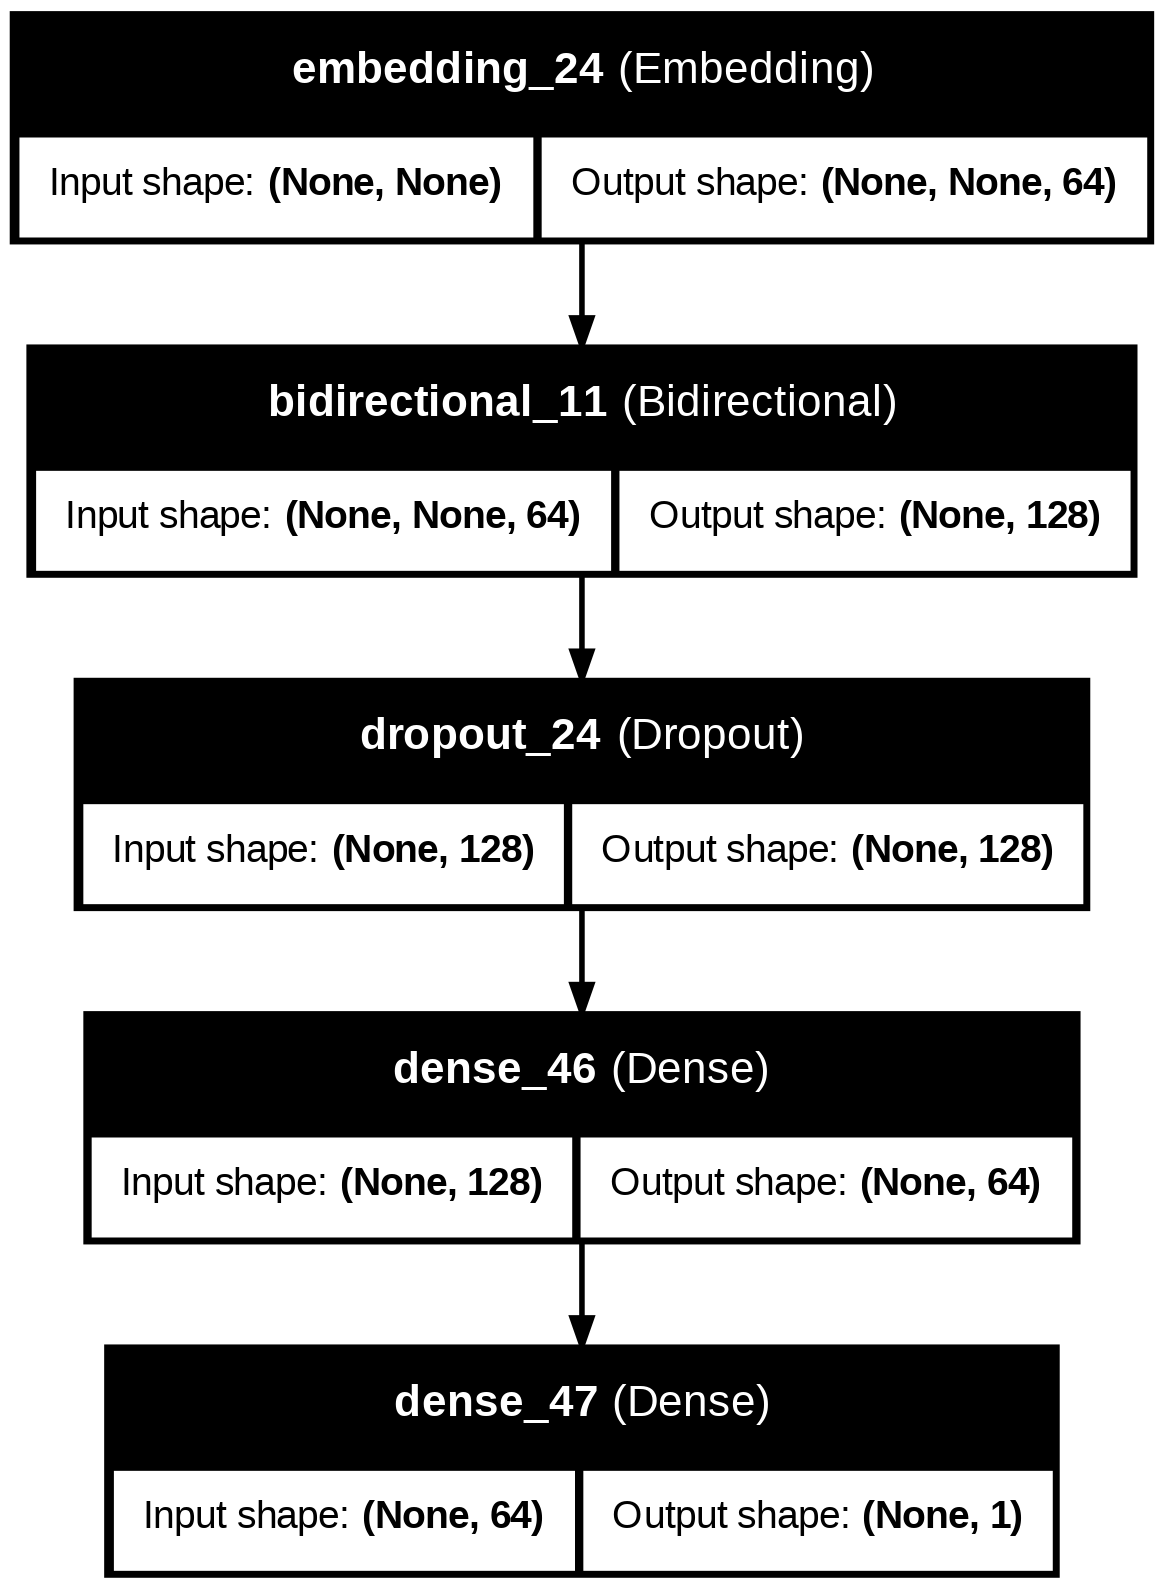

In [168]:
plot_model(model, to_file='modelo_imdb.png', show_shapes=True, show_layer_names=True)
Image(filename='modelo_imdb.png')